<a href="https://colab.research.google.com/github/anggithaycs/malin-used-cars/blob/master/Teknik_1_Project_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.model_selection import train_test_split # used for splitting training and testing data
from sklearn.preprocessing import MinMaxScaler # used for feature scaling
from sklearn.decomposition import PCA #used for feature extraction

# Data Preparation
Mounting to my Drive, dataset awal terdapat 20000 tuple dan 26 atribut.

In [0]:
df = pd.read_csv("drive/My Drive/ProjectMalin/used_cars.csv")

# Data Preprocessing
1. Sebelum memulai semuanya, penting untuk memahami dataset.
2. Lakukan analisis pada atribut dalam dataset. Berhubung jumlah dimensi dataset awal tidak terlalu banyak maka analisa dapat dilakukan secara manual. Pengecekan dapat dilakukan ddengan memanggil isnull() dari dataframe atau melihat 5 tuple teratas.

In [0]:
df.isnull().sum()

Unnamed: 0         0
region             0
price              0
year              12
manufacturer     705
model            265
condition       9152
cylinders       7085
fuel              73
odometer        2389
title_status     110
transmission     190
drive           4642
type            3659
paint_color     5514
dtype: int64

3. [Data Cleaning] Setelah mengecek nilai null, dapat dilihat atribut dengan missing value lebih dari 50% total tuple. Mada dari itu kolom 'size' dan 'county' di-drop.
4. [Data Cleaning] Dataset ini tidak memiliki label, namun dari data dan link pada url dalam dataset dapat dilihat bahwa dataset ini untuk jual beli mobil. Asumsi yang dilakukan adalah disini tidak akan dilakukan pemrosesan teks, link url, dan gambar. Maka dari itu kolom 'url', 'region_url', 'image_url', 'description' di-drop.
5. [Data Cleaning] Selanjutnya perlu diasumsikan dari atribut tersisa, mana saja yang tidak dibutuhkan dalam pembelian mobil. Maka dari itu kolom 'vin' di-drop.
6. [Data Cleaning] Ada lebih dari 1 atribut yang menyangkut tempat yaitu: 'region', 'state', 'lat', 'long'. Namun ada dikerucutkan menjadi satu atribut saja yaitu 'region' karena orang-orang cenderung membeli mobil di daerahnya dengan pemahaman lebih dekat dibanding kota lain dalam satu negara bagian (state). Long dan lat terasa tidak dibutuhkan karena kita tidak mengolah data spasial. Maka atribut 'state', 'long', 'lat' di-drop.
7. [Data Cleaning] Drop atribut unnamed karena sama dengan index. Atribut ini biasanya auto-generated sama mengubah dataframe menjadi csv. Selanjutnya, tahap ini akan sering dilakukan.
8. [Data Cleaning] Drop atribut 'id' karena menurut saya tidak memiliki dampak signifikan.

In [0]:
#3 Drop atribut size dan county
df.drop(df.columns[df.columns.str.contains('county',case = False)],axis = 1, inplace = True)
df.drop(df.columns[df.columns.str.contains('size',case = False)],axis = 1, inplace = True)

#4 Drop url, region_url, image_url, dan description
df.drop(df.columns[df.columns.str.contains('url',case = False)],axis = 1, inplace = True)
df.drop(df.columns[df.columns.str.contains('region_url',case = False)],axis = 1, inplace = True)
df.drop(df.columns[df.columns.str.contains('image_url',case = False)],axis = 1, inplace = True)
df.drop(df.columns[df.columns.str.contains('description',case = False)],axis = 1, inplace = True)

#5 Drop vin
df.drop(df.columns[df.columns.str.contains('vin',case = False)],axis = 1, inplace = True)

#6 Drop state, lat, long
df.drop(df.columns[df.columns.str.contains('state',case = False)],axis = 1, inplace = True)
df.drop(df.columns[df.columns.str.contains('lat',case = False)],axis = 1, inplace = True)
df.drop(df.columns[df.columns.str.contains('long',case = False)],axis = 1, inplace = True)

#7 Drop unnamed
df.drop(df.filter(regex="Unnamed"),axis=1, inplace=True)

#8 Drop ID
df.drop(df.columns[df.columns.str.contains('id',case = False)],axis = 1, inplace = True)

9. [Data Cleaning] Menghapus rows yang memiliki missing value pada atribut year.

In [0]:
# Drop rows if all the selected columns contains NaN only i.e.
df = df.dropna(axis = 0, subset=['year'])

10. [Data Cleaning] Menghapus row yang memiliki missing value >= 6

In [0]:
df = df[df.isnull().sum(axis=1) < 6]

11. [Data Cleaning] Menghapus rows dengan price < 1500

In [0]:
df.drop(df[df.price < 1500 ].index, inplace=True)

12. [Data Cleaning - Missing Value] Tentukan tipe data: int = [price, odometer], nominal = [region, manufacturer, model, paint color, fuel], ordinal = [year, condition, cylinders, title_status, transmission, drive, type]. Dari tiap tipe data, tentukan yang masih memiliki missing value. Handle missing value year dengan di drop, odometer dengan rata-rata, dan sisanya dengan modus.

In [0]:
df.isnull().sum()

region             0
price              0
year               0
manufacturer     469
model            167
condition       6201
cylinders       5201
fuel              30
odometer        1185
title_status      83
transmission     179
drive           3084
type            2398
paint_color     3910
dtype: int64

In [0]:
#Isi missing value odometer dengan mean
df['odometer'] = df['odometer'].fillna(df['odometer'].mean())

Condition suatu mobil penting untuk menentukan mobil itu diminati atau tidak. Maka dari itu kita lihat distribusi datanya terlebih dahulu sebelum mengisi dengan modus.

In [0]:
#Mengisi missing value condition
df['condition'].value_counts()
#Rank: 1. salvage, 2. fair, 3. good, 
#4.excellent, 5. like new 6. new

excellent    5199
good         3920
like new      649
fair          207
new            25
salvage        12
Name: condition, dtype: int64

Dengan asumsi atribut condition adalah atribut ordinal dengan susunan berikut : salvage < fair < good < excellent < like new < new. Maka saya memutuskan untuk tetap mengisi condition dengan modus, karena modusnya merupakan nilai tengah.

In [0]:
a_kategori = ['manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','type','paint_color']
for j in a_kategori:
  df[j] = df[j].fillna(df[j].mode().values[0])

Cek jika masih ada missing value

In [0]:
df.isnull().sum()

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
dtype: int64

13. [Data Cleaning - Outlier] Mengatasi outlier pada atribut 'price', 'year', dan 'odometer'. Atribut 'year' memiliki tipe data float64, maka masih bisa dilakukan deteksi outlier. Selain itu deteksi outlier juga perlu untuk mendeteksi non-sense data seperti mobil yang tahun pembuatannya di bawah tahun ditemukannya mobil (jika terdapat tuple seperti ini).

In [0]:
#import seaborn untuk melihat persebaran price, year, dan odometer dalam boxplot
import seaborn as sns

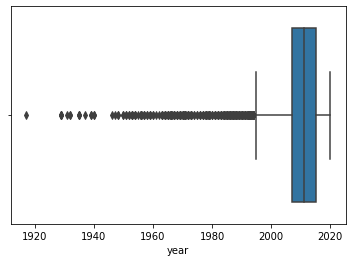

In [0]:
sns.boxplot(x=df['year'])

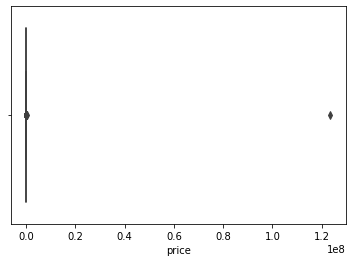

In [0]:
sns.boxplot(x=df['price'])

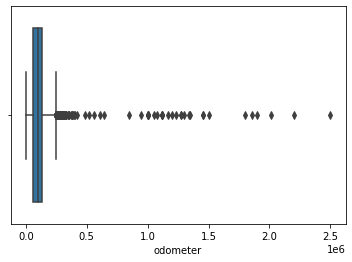

In [0]:
sns.boxplot(x=df['odometer'])

Boxplot yang menampilkan persebaran data price dan odometer tidak dapat memvisualisasikan dengan baik karena persebaran data yang terlalu abstrak, maka dari itu didefinisikan fungsi remove outlier untuk diaplikasikan pada ketiga atribut ini.

In [0]:
def rmvOutlier(df,column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    interq = q3-q1
    batasBawah = q1-1.5*interq
    batasAtas = q3+1.5*interq
    df_out =  df.loc[(df[column] > batasBawah) & (df[column] < batasAtas)]
    return df_out

In [0]:
#Remove outlier dilakukan dua kali, yang pertama untuk handling outlier dan yang kedua untuk recheck 
df = rmvOutlier(df, 'year')
df = rmvOutlier(df, 'year')

Menampilkan boxplot year setelah outlier dihapus

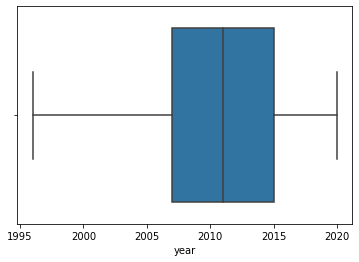

In [0]:
sns.boxplot(x=df['year'])

In [0]:
df = rmvOutlier(df, 'price')
df = rmvOutlier(df, 'price')

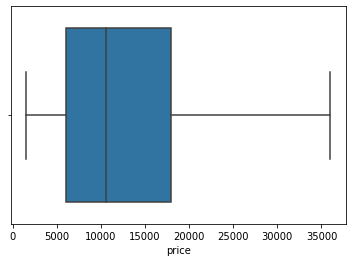

In [0]:
sns.boxplot(x=df['price'])

In [0]:
df = rmvOutlier(df, 'odometer')
df = rmvOutlier(df, 'odometer')

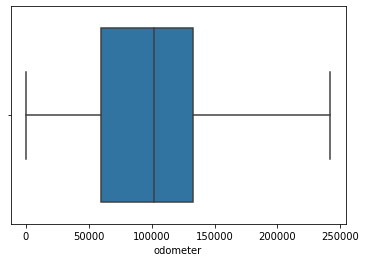

In [0]:
sns.boxplot(x=df['odometer'])

In [0]:
#Mengubah data untuk nantinya ditempelkan atribut kelas
df.to_csv("drive/My Drive/ProjectMalin/Preprocessing1/clean_data.csv", index=False)

In [0]:
ds = df

14. [Data Cleaning - Mengubah Nominal dan Ordinal Menjadi Numerik] Data ordinal diubah dengan replacing dan data nominal diubah menggunakan encoder. Sebelumnya lakukan perhitungan value count dari tiap kolom. Misalnya title_status, sudah tidak ada mobil yang parts only.

In [0]:
#Mengganti value data ordinal dengan replacing dari tingkat rendah ke tinggi berdasar value pada money
df['condition'] = df['condition'].replace({'salvage': 1, 'fair': 2, 'good': 3, 'excellent':4, 'like new':5, 'new':6})

df['cylinders'] = df['cylinders'].replace({'other': 1, '3 cylinders': 2, '4 cylinders': 3, '5 cylinders':4,
                                           '6 cylinders':5, '8 cylinders':6, '10 cylinders':7, '12 cylinders':8})
#sudah tidak ada title_status == 'parts only'
df['title_status'] = df['title_status'].replace({'missing': 1, 'salvage':2, 'rebuilt': 3, 'lien':4, 'clean':5})

df['transmission'] = df['transmission'].replace({'other':1, 'manual':2, 'automatic':3})

df['drive'] = df['drive'].replace({'fwd':1, 'rwd':2, '4wd':3})

df['type'] = df['type'].replace({'other':1, 'hatchback':2, 'wagon':3, 'sedan':4, 'mini-van':5, 'van':6, 'pickup':7,
                                 'SUV':8, 'offroad':9, 'truck':10, 'bus':11, 'coupe':12, 'convertible':13})

In [0]:
kategori = ['region','manufacturer','model','fuel','paint_color']
for i in kategori:
  num = LabelEncoder()
  df[i] = num.fit_transform(df[i].astype('str'))

Cek tipe data tiap atribut dan ubah ke numerik

In [0]:
df.dtypes

region            int64
price             int64
year            float64
manufacturer      int64
model             int64
condition         int64
cylinders         int64
fuel              int64
odometer        float64
title_status      int64
transmission      int64
drive             int64
type              int64
paint_color       int64
dtype: object

cast odometer dan year menjadi int64

In [0]:
df['odometer'] = df['odometer'].astype(np.int64)

In [0]:
df['year'] = df['year'].astype('int64')

14. [Data Cleaning - Scaling] Scaling menggunakan minmax.

In [0]:
#Scaling menggunakan minmax
mms = MinMaxScaler()
df_new = mms.fit_transform(df)
df_new = pd.DataFrame(df_new,columns=df.columns)

In [0]:
df = df_new

In [0]:
df.to_csv("drive/My Drive/ProjectMalin/Preprocessing1/used_cars_after_scaling.csv", index = False) 

In [0]:
df_alrscal = df

Range data tiap kolom sudah sama.

#Reduksi Dimensi
Saat ini saya menggunakan PCA dengan library dengan n components 0.3 agar menghasilkan 2 atribut.

In [0]:
pca = PCA(n_components=0.30, whiten=True)

#Mencari Hasil PCA, ditransform ke 0.3 supaya tersisa 2 atribut untuk clustering
df_pca = pca.fit_transform(df)


In [0]:
df_pca = pd.DataFrame(df_pca)

In [0]:
df_pca.count()

x                  14913
y                  14913
distance_from_1    14913
distance_from_2    14913
distance_from_3    14913
closet             14913
color              14913
dtype: int64

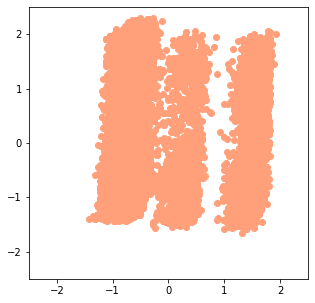

In [0]:
fig = plt.figure(figsize=(5,5))
plt.scatter(df_pca[0], df_pca[1], color = 'lightsalmon')
plt.xlim(-2.5,2.5) #limit disesuaikan dengan persebaran data agar terlihat jelas
plt.ylim(-2.5,2.5)
plt.show()

#Clustering
Data dengan 2 atribut dari hasil PCA digunakan untuk membangun model K-Means clustering 3 kelas. Hal ini dikarenakan K-Means clustering requires 2 atribut.

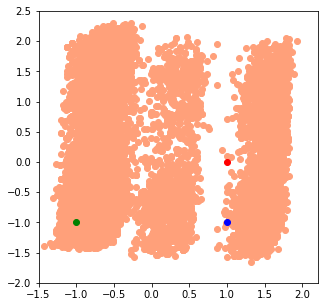

In [0]:
a = df_pca.iloc[:, 0] #matrix baru, pake semua baris, tapi kecuali kolom terakhir
b = df_pca.iloc[:, 1] #matrix baru, pake semua baris, tapi kolom kelas saja

c = {'x':a, 'y':b}

df_pca = pd.DataFrame(c)

np.random.seed(200)
k = 3

centroids = {
    i+1: [np.random.randint(-1.5, 2), np.random.randint(-1.6,2.5)]
    for i in range(k)
}

fig = plt.figure(figsize=(5,5))
plt.scatter(df_pca['x'], df_pca['y'], color='lightsalmon')
colmap = {1: 'r', 2: 'g', 3: 'b'}
for i in centroids.keys():
    plt.scatter(*centroids[i], color = colmap[i])
plt.xlim(-1.5,2.2)
plt.ylim(-2,2.5)
plt.show()

          x         y  distance_from_1  ...  distance_from_3  closet  color
0 -0.362352  1.934049         2.365703  ...         3.234911       1      r
1 -0.687304 -0.120818         1.691624  ...         1.902618       2      g
2 -1.107400 -0.675560         2.213033  ...         2.132228       2      g
3 -0.825103 -0.462807         1.882868  ...         1.902519       2      g
4 -0.738797 -0.441103         1.793875  ...         1.826412       2      g

[5 rows x 7 columns]


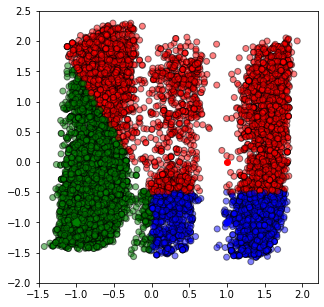

In [0]:
def assignment(df, centroids):
    for i in centroids.keys():
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['x'] - centroids[i][0]) ** 2
                + (df['y'] - centroids[i][1]) ** 2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
    df['closet'] = df.loc[:, centroid_distance_cols].idxmin(axis = 1)
    df['closet'] = df['closet'].map(lambda x : int(x.lstrip('distance_from_')))
    df['color'] = df['closet'].map(lambda x : colmap[x])
    return df

df_pca = assignment(df_pca,centroids)
print(df_pca.head())

fig = plt.figure(figsize=(5,5))
plt.scatter(df_pca['x'], df_pca['y'], color = df_pca['color'], alpha = 0.5, edgecolor = 'k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color = colmap[i])
plt.xlim(-1.5,2.2)
plt.ylim(-2,2.5)
plt.show()

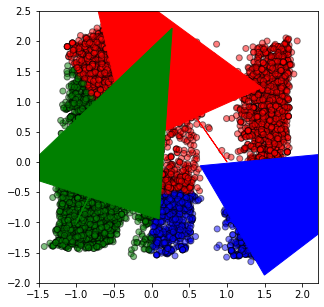

In [0]:
import copy

old_centroids = copy.deepcopy(centroids)
def update(k):
  for i in centroids.keys():
    centroids[i][0] = np.mean(df_pca[df_pca['closet'] == i]['x'])
    centroids[i][1] = np.mean(df_pca[df_pca['closet'] == i]['y'])
  return k

centroids = update(centroids)

fig = plt.figure(figsize=(5,5))
ax = plt.axes()
plt.scatter(df_pca['x'], df_pca['y'], color = df_pca['color'], alpha = 0.5, edgecolor = 'k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color = colmap[i])
plt.xlim(-1.5,2.2)
plt.ylim(-2,2.5)

for i in old_centroids.keys():
  old_x = old_centroids[i][0]
  old_y = old_centroids[i][1]
  dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
  dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
  ax.arrow(old_x, old_y, dx, dy, head_width = 2, head_length=3, fc = colmap[i], ec= colmap[i])

plt.show()

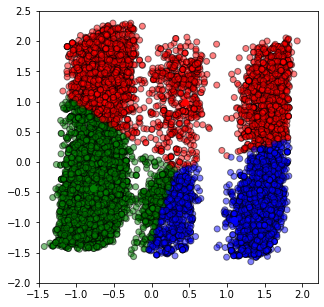

In [0]:
#Ulang assignment
df_pca = assignment(df_pca,centroids)

#Plot results
fig = plt.figure(figsize=(5,5))
plt.scatter(df_pca['x'], df_pca['y'], color = df_pca['color'], alpha = 0.5, edgecolor = 'k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color = colmap[i])
plt.xlim(-1.5,2.2)
plt.ylim(-2,2.5)
plt.show()

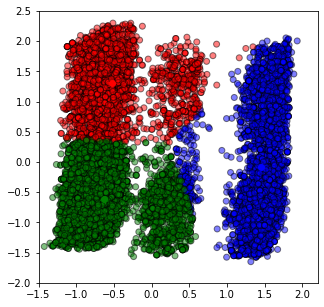

In [0]:
while True:
  closest_centroids = df_pca['closet'].copy(deep=True)
  centroids = update(centroids)
  df_pca = assignment(df_pca, centroids)
  if closest_centroids.equals(df_pca['closet']):
    break

#Membuat plot hasil
fig = plt.figure(figsize=(5,5))
plt.scatter(df_pca['x'], df_pca['y'], color = df_pca['color'], alpha = 0.5, edgecolor = 'k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color = colmap[i])
plt.xlim(-1.5,2.2)
plt.ylim(-2,2.5)
plt.show()

In [0]:
df_pca.head()

,x,y,distance_from_1,distance_from_2,distance_from_3,closet,color
0,-0.362352,1.934049,0.649419,2.556790,2.713018,1,r
1,-0.687304,-0.120818,1.436255,0.490404,2.140077,2,g
2,-1.107400,-0.675560,2.064565,0.478373,2.627603,2,g
3,-0.825103,-0.462807,1.793987,0.240355,2.309046,2,g
4,-0.738797,-0.441103,1.760318,0.197436,2.220356,2,g


Atribut closet adalah atribut kelas hasil Clustering. Masukkan atribut ini ke dataframe setelah scaling untuk melakukan klasifikasi.

In [0]:
df['class'] = df_pca['closet']

#Classification 
Dalam pengerjaan project ini dilakukan klasifikasi dengan menggunakan model Naive Bayes, KNN, dan Random Forest. Data masukan adalah data sesudah scaling karena kedua model ini membaca masukan numerikal.

In [0]:
#Libraries for Gaussian NB and KNN
import collections
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

Split dataset dilakukan satu kali sekaligus untuk model Naive Bayes dan KNN, maka data train dan data test pada kedua model adalah sama. Dengan ini diharapkan bisa secara real melihat perbandingan performansi kedua model ini.

In [0]:
#Split dataset untuk klasifikasi hanya dilakukan satu kali, maka data test NB sama dengan KNN
X = df.iloc[:, :-1].values #matrix baru, pake semua baris, tapi kecuali kolom terakhir
y = df.iloc[:, 14].values #matrix baru, pake semua baris, tapi kolom kelas saja
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [0]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [0]:
print(y_pred)
print('\n')
print("Akurasi Model Naive Bayes:",metrics.accuracy_score(y_test, y_pred))
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('\n')
print("Classification Report for Naive Bayes")
print(classification_report(y_test,y_pred))

[3 2 3 ... 1 1 3]


Akurasi Model Naive Bayes: 0.9648005363727791


Confusion Matrix
[[ 706    4    0]
 [  71 1360    1]
 [  14   15  812]]


Classification Report for Naive Bayes
              precision    recall  f1-score   support

           1       0.89      0.99      0.94       710
           2       0.99      0.95      0.97      1432
           3       1.00      0.97      0.98       841

    accuracy                           0.96      2983
   macro avg       0.96      0.97      0.96      2983
weighted avg       0.97      0.96      0.97      2983



In [0]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [0]:
print(y_pred)
print('\n')
print("Akurasi Model KNN:",metrics.accuracy_score(y_test, y_pred))
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('\n')
print("Classification Report for KNN")
print(classification_report(y_test,y_pred))

[3 2 3 ... 1 1 3]


Akurasi Model KNN: 0.9798860207844452


Confusion Matrix
[[ 688   21    1]
 [  20 1409    3]
 [   8    7  826]]


Classification Report for KNN
              precision    recall  f1-score   support

           1       0.96      0.97      0.96       710
           2       0.98      0.98      0.98      1432
           3       1.00      0.98      0.99       841

    accuracy                           0.98      2983
   macro avg       0.98      0.98      0.98      2983
weighted avg       0.98      0.98      0.98      2983



In [0]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [0]:
print(y_pred)
print('\n')
print("Akurasi Model Random Forest:",metrics.accuracy_score(y_test, y_pred))
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('\n')
print("Classification Report for Random Forest")
print(classification_report(y_test,y_pred))

[3 2 3 ... 1 1 3]


Akurasi Model Random Forest: 0.9879316124706671


Confusion Matrix
[[ 706    4    0]
 [  12 1420    0]
 [  10   10  821]]


Classification Report for Random Forest
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       710
           2       0.99      0.99      0.99      1432
           3       1.00      0.98      0.99       841

    accuracy                           0.99      2983
   macro avg       0.99      0.99      0.99      2983
weighted avg       0.99      0.99      0.99      2983



#Merapihkan dataframe untuk dijadikan file csv

In [0]:
ds['class'] = df['class']

In [0]:
ds.to_csv("drive/My Drive/ProjectMalin/Preprocessing1/clean_data_with_label.csv", index = False)

In [0]:
df_alrscal.to_csv("drive/My Drive/ProjectMalin/Preprocessing1/after_scaling_with_label.csv", index = False)